# The preparation
After downloading the data, unpack it and move to any preferred destination. For this example we will be interested only in stage1_train and stage1_test subdirectories, thus other files could be put aside. Let's take a look at the exemplary image.

In [1]:
from pathlib import Path
import os
import pandas as pd
cwd = Path.cwd()
while cwd.stem != "pyplatypus":
    cwd = cwd.parent
os.chdir(cwd)

In [2]:
cloud_path = "examples/data/38-Cloud/38-Cloud_training/train_gt/"
mask_paths = [os.path.join(cloud_path, mp) for mp in os.listdir(cloud_path)]
red_images_paths = [mp.replace('gt', 'red') for mp in mask_paths]
green_images_paths = [mp.replace('gt', 'green') for mp in mask_paths]
blue_images_paths = [mp.replace('gt', 'blue') for mp in mask_paths]
nir_images_paths = [mp.replace('gt', 'nir') for mp in mask_paths]
config_df = pd.DataFrame({
    'images': [r + ';' + g + ';' + b + ';' + n for r, g, b, n in zip(red_images_paths, green_images_paths, blue_images_paths, nir_images_paths)],
    'masks': mask_paths
})
config_df.iloc[0:5040, :].to_csv('examples/30_clouds_train.csv', index=False)
config_df.iloc[5040:6720, :].to_csv('examples/30_clouds_validation.csv', index=False)
config_df.iloc[6720:, :].to_csv('examples/30_clouds_test.csv', index=False)

Let's now inspect the input message that we are to send to PlatypusSolver in order to run it.

In [3]:
import yaml
import json
with open(r"examples/claud_38_config.yaml") as stream:
    config = yaml.safe_load(stream)
    print(json.dumps(config, indent=4, sort_keys=True))

{
    "object_detection": null,
    "semantic_segmentation": {
        "data": {
            "colormap": [
                [
                    0,
                    0,
                    0
                ],
                [
                    255,
                    255,
                    255
                ]
            ],
            "column_sep": ";",
            "mode": "config_file",
            "shuffle": false,
            "subdirs": [
                "images",
                "masks"
            ],
            "train_path": "examples/30_clouds_train.csv",
            "validation_path": "examples/30_clouds_validation.csv"
        },
        "models": [
            {
                "activation_layer": "relu",
                "augmentation": {
                    "Blur": {
                        "always_apply": false,
                        "blur_limit": 7,
                        "p": 0.5
                    },
                    "Flip": {
                        "

What might have struck you is that the config is organized so that it might potentially tell the Solver to train multiple models while using a complex augmentation pipeline and loss functions coming from the rather large set of ones available within the PyPlatypus framework.

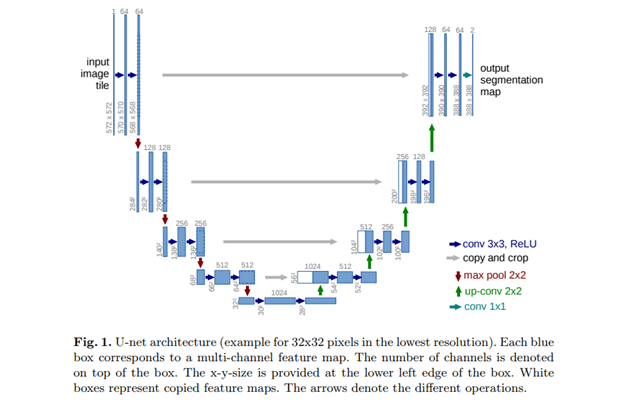

# The model

The models present in the PyPlatypus segmentation submodule are U-Net based.

U-Net was originally developed for biomedical data segmentation. As you can see in the picture above architecture is very similar to autoencoder and it looks like the letter U, hence the name. Model is composed of 2 parts, and each part has some number of convolutional blocks (3 in the image above). Number of blocks will be hyperparameter in our model.

To build a U-Net model in platypus use u_net function. You have to specify:

* Number of convolutional blocks,
* Input image height and width - it need not to be in the form 2^N, as we added the generalizng layer.
* Indicator determining if the input image will be loaded as grayscale or RGB.
* Number of classes - in our case we have only 2 (background and nuclei).
* Additional arguments for CNN such as: number of filters, dropout rate etc.

Hereafter the models' building process is rather straightforward.

In [4]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver


ps = PlatypusSolver(
    config_yaml_path=Path("examples/claud_38_config.yaml")
)
ps.train()

5040 images detected!
Set 'steps_per_epoch' to: 158
1680 images detected!
Set 'steps_per_epoch' to: 53


2022-10-12 21:24:22.953609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 21:24:22.958717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 21:24:22.958930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 21:24:22.959592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-10-12 21:24:31.707394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


158/158 [==============================] - 488s 3s/step - loss: 0.1611 - categorical_crossentropy: 0.4626 - dice_coefficient: 0.6246 - iou_coefficient: 0.4574 - tversky_coefficient: 0.5237 - val_loss: 0.2437 - val_categorical_crossentropy: 0.6301 - val_dice_coefficient: 0.5095 - val_iou_coefficient: 0.3418 - val_tversky_coefficient: 0.4059
Epoch 2/100
158/158 [==============================] - 466s 3s/step - loss: 0.0857 - categorical_crossentropy: 0.2694 - dice_coefficient: 0.7692 - iou_coefficient: 0.6260 - tversky_coefficient: 0.6845 - val_loss: 0.2125 - val_categorical_crossentropy: 0.5803 - val_dice_coefficient: 0.5372 - val_iou_coefficient: 0.3673 - val_tversky_coefficient: 0.4327
Epoch 3/100
158/158 [==============================] - 466s 3s/step - loss: 0.0698 - categorical_crossentropy: 0.2134 - dice_coefficient: 0.8155 - iou_coefficient: 0.6893 - tversky_coefficient: 0.7408 - val_loss: 0.1712 - val_categorical_crossentropy: 0.4942 - val_dice_coefficient: 0.5967 - val_iou_coef

Epoch 13/100
630/630 [==============================] - 479s 760ms/step - loss: 0.0560 - categorical_crossentropy: 0.1631 - tversky_coefficient: 0.7946 - dice_coefficient: 0.8571 - iou_coefficient: 0.7530 - val_loss: 0.0505 - val_categorical_crossentropy: 0.1875 - val_tversky_coefficient: 0.7519 - val_dice_coefficient: 0.8242 - val_iou_coefficient: 0.7034
Epoch 14/100
630/630 [==============================] - 479s 760ms/step - loss: 0.0527 - categorical_crossentropy: 0.1566 - tversky_coefficient: 0.7996 - dice_coefficient: 0.8610 - iou_coefficient: 0.7588 - val_loss: 0.1904 - val_categorical_crossentropy: 0.3591 - val_tversky_coefficient: 0.6852 - val_dice_coefficient: 0.7681 - val_iou_coefficient: 0.6297
Epoch 15/100
630/630 [==============================] - 478s 758ms/step - loss: 0.0535 - categorical_crossentropy: 0.1571 - tversky_coefficient: 0.8001 - dice_coefficient: 0.8613 - iou_coefficient: 0.7596 - val_loss: 0.0447 - val_categorical_crossentropy: 0.1745 - val_tversky_coeffic

Epoch 36/100
630/630 [==============================] - 481s 763ms/step - loss: 0.0407 - categorical_crossentropy: 0.1206 - tversky_coefficient: 0.8364 - dice_coefficient: 0.8890 - iou_coefficient: 0.8032 - val_loss: 0.0505 - val_categorical_crossentropy: 0.1320 - val_tversky_coefficient: 0.8290 - val_dice_coefficient: 0.8838 - val_iou_coefficient: 0.7951
Epoch 37/100
630/630 [==============================] - 478s 759ms/step - loss: 0.0431 - categorical_crossentropy: 0.1272 - tversky_coefficient: 0.8296 - dice_coefficient: 0.8839 - iou_coefficient: 0.7949 - val_loss: 0.0357 - val_categorical_crossentropy: 0.1185 - val_tversky_coefficient: 0.8301 - val_dice_coefficient: 0.8848 - val_iou_coefficient: 0.7961
Epoch 38/100
630/630 [==============================] - 479s 760ms/step - loss: 0.0391 - categorical_crossentropy: 0.1171 - tversky_coefficient: 0.8395 - dice_coefficient: 0.8913 - iou_coefficient: 0.8069 - val_loss: 0.0363 - val_categorical_crossentropy: 0.1202 - val_tversky_coeffic

Epoch 59/100
630/630 [==============================] - 719s 1s/step - loss: 0.0351 - categorical_crossentropy: 0.1049 - tversky_coefficient: 0.8518 - dice_coefficient: 0.9006 - iou_coefficient: 0.8219 - val_loss: 0.0508 - val_categorical_crossentropy: 0.1393 - val_tversky_coefficient: 0.8180 - val_dice_coefficient: 0.8753 - val_iou_coefficient: 0.7819
Epoch 60/100
630/630 [==============================] - 548s 869ms/step - loss: 0.0348 - categorical_crossentropy: 0.1037 - tversky_coefficient: 0.8532 - dice_coefficient: 0.9017 - iou_coefficient: 0.8236 - val_loss: 0.0360 - val_categorical_crossentropy: 0.1138 - val_tversky_coefficient: 0.8369 - val_dice_coefficient: 0.8900 - val_iou_coefficient: 0.8044
Epoch 61/100
630/630 [==============================] - 558s 886ms/step - loss: 0.0359 - categorical_crossentropy: 0.1071 - tversky_coefficient: 0.8496 - dice_coefficient: 0.8990 - iou_coefficient: 0.8192 - val_loss: 0.0273 - val_categorical_crossentropy: 0.0945 - val_tversky_coefficien

In [ ]:
x = ps.sample_generator('38c_u_net_plus_plus')
x[1][0, :, :, 1].max()

In [ ]:
x[0].shape

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(x[0][0, :, :, 3])

In [ ]:
x = ps.sample_generator('bulls_u_net', training_augmentation = True)
print(x.shape)
import matplotlib.pyplot as plt
plt.matshow(x[0,:,:,:])

In [ ]:
ps.evaluate_models('data/config_file_train.csv')

In [ ]:
from pyplatypus.segmentation.models.stacked_ensemble import stacked_ensembler
from tensorflow.keras.utils import plot_model
model1 = ps.cache["semantic_segmentation"]['bulls_u_net']['model']
model2 = ps.cache["semantic_segmentation"]['bulls_u_net_plus_plus']['model']
members = [model1, model2]
ens = stacked_ensembler(members, 2, 300, 300, 16, (3, 3), 2, True, 0.1, True, "he_normal", True, "relu").model
plot_model(ens, show_shapes=True, to_file='model_graph.png')
ens.summary()

In [ ]:
ps.cache['semantic_segmentation']['bulls_u_net']['training_history']

# Predictions

Only after do we train the models, we can easily produce predicted masks based on the validation set or whatever data that we would like to use, just make sure it is organized as in the train/validation/test sets.

In [ ]:
from glob import glob
from random import sample
from PIL import Image
import numpy as np

def prepare_masks(masks, np_original_size, masks_frame):
    for mask in masks:
        loaded_mask_ = plt.imread(mask)
        if loaded_mask_.shape != np_original_size:
            rotated_loaded_mask_ = np.rot90(loaded_mask_)
            masks_frame += rotated_loaded_mask_
        else:
            masks_frame += loaded_mask_
    return masks_frame

def sample_and_plot_predictions(data_path: Path, model_name: str, n=3):
    validation_images = glob(str(data_path/Path("stage1_validation/*")))
    # Sample size
    n_max = len(validation_images)
    n=n_max if n > n_max else n
    validation_images = sample(validation_images, n)
    for img_path in validation_images:
        img_name = img_path.split("/")[-1:][0]
        img = glob(f"{img_path}/images/*.png")[0]
        predictions = glob(f"{img_path}/predicted_masks/{model_name}_predicted_mask.png")[0]
        masks = glob(f"{img_path}/masks/*.png")
        # Load images
        img_loaded = Image.open(img) 
        original_size = img_loaded.size
        np_original_size = tuple(reversed(original_size))
        # Load masks and squeeze them into one frame
        masks_frame = np.zeros(np_original_size)
        masks_frame = prepare_masks(masks, np_original_size, masks_frame)
        # Load predictions
        predictions_loaded = Image.open(predictions)
        original_size_scaled = (np.array(original_size)/2).astype(int)
        predictions_scaled = predictions_loaded.resize(original_size_scaled)
        # Plot image alongside true and predicted masks
        f, axarr = plt.subplots(1,3)
        plt.title(f"Image and predictions: {img_name}")
        axarr[0].imshow(img_loaded)
        axarr[1].imshow(masks_frame)
        axarr[2].imshow(predictions_scaled)

In [ ]:
# Clean the results of former runs
from glob import glob
from shutil import rmtree
masks = glob(str(data_path/"stage1_validation/**/predicted_*"))
for mask in masks:
    rmtree(mask)


In [ ]:
# When the custom_data_path is set to None, the validation data will be used.
# If that is not the intention of yours, feel free to point the engine to any other direction.pyplatypus.com
ps.produce_and_save_predicted_masks_for_model(model_name="bulls_u_net", custom_data_path=None)
ps.produce_and_save_predicted_masks_for_model(model_name="bulls_u_net", custom_data_path='data/config_file_test.csv')

In [ ]:
# When the custom_data_path is set to None, the validation data will be used.
# If that is not the intention of yours, feel free to point the engine to any other direction.pyplatypus.com
ps.produce_and_save_predicted_masks_for_model(model_name="bulls_u_net_plus_plus", custom_data_path=None)
ps.produce_and_save_predicted_masks_for_model(model_name="bulls_u_net_plus_plus", custom_data_path='data/config_file_test.csv')

In [ ]:
sample_and_plot_predictions(data_path, model_name="bulls_u_net", n=10)